In [6]:
from pathlib import Path
import torch
from torch import nn

# 1. Create models directory
PATH = Path.cwd()
NAME = 'classification_moons.pth'
SAVE_PATH = PATH / 'models' / NAME
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def duplicate_model(loaded_model):
    # Create new instance of model and load saved state dict (make sure to put it on the target device)
    loaded_model.load_state_dict(torch.load(SAVE_PATH))
    loaded_model.to(device)
    return loaded_model


# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    ## Your code here ##
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2,10)
        self.layer_2 = nn.Linear(10,10)
        self.layer_3 = nn.Linear(10,10)
        self.layer_4 = nn.Linear(10,1)
        self.relu = nn.ReLU()


    def forward(self, x):
        ## Your code here ##
        return self.relu(self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))))))

# Instantiate the model
## Your code here ##
model = MoonModelV0()
model = duplicate_model(model)


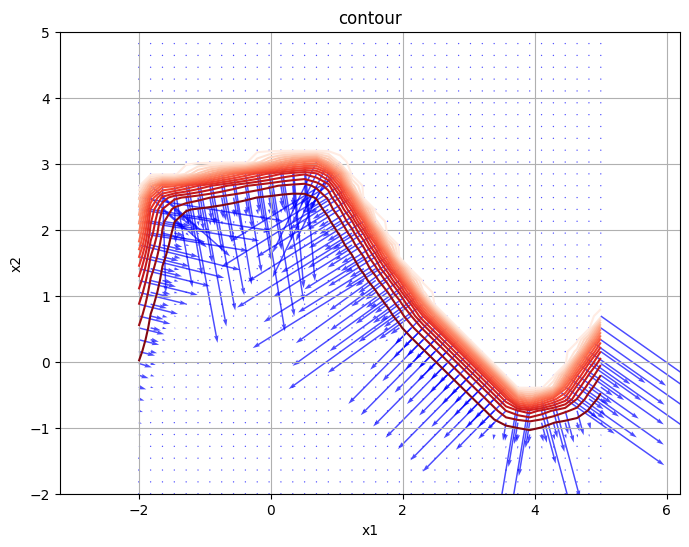

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import grad

# --- Ensure model is in eval mode ---
model.eval()

# --- Helper: compute log-probability score gradient ---
def compute_score(x, model, target_label=1):
    x = x.clone().detach().requires_grad_(True)
    out = model(x)  # shape (N, 1)
    logit = out.squeeze(1)  # (N,)
    # Convert to probability via sigmoid since it's binary classification
    prob = torch.sigmoid(logit)
    log_prob = torch.log(prob) if target_label == 1 else torch.log(1 - prob)
    grad_val = grad(log_prob.sum(), x, create_graph=False)[0]  # shape (N, 2)
    return grad_val.detach().cpu()

# --- Create a 2D meshgrid (4×4 or more) ---
grid_size = 40  # use 4 for very coarse, 20 for smooth
x_range = y_range = torch.linspace(-2, 5, grid_size)
xx, yy = torch.meshgrid(x_range, y_range, indexing='ij')
mesh_points = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)  # shape (N, 2)

# --- Compute scores ---
scores = compute_score(mesh_points, model, target_label=1)

# --- Convert to NumPy for plotting ---
X = mesh_points[:, 0].cpu().numpy()
Y = mesh_points[:, 1].cpu().numpy()
U = scores[:, 0].numpy()
V = scores[:, 1].numpy()

# --- Quiver Plot: Score Vector Field ---
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, color='blue', alpha=0.7)
plt.title("Score Field: ∇ log p(y=1|x)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.axis("equal")

# --- Contour Plot: log p(y=1|x) ---
with torch.no_grad():
    prob = torch.sigmoid(model(mesh_points)).squeeze(1).cpu().numpy()
    log_prob = np.log(prob)

Z = log_prob.reshape(grid_size, grid_size)
plt.contour(xx.cpu(), yy.cpu(), Z, levels=20, cmap='Reds')
plt.title('contour')
plt.show()
